In [1]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
fLNM_DIR = DATA_DIR / "processed" / "fLNM_2mm_leaddbs"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "matters_arising"

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Load data

In [ ]:
import nibabel as nib
import numpy as np

# Downloaded from https://github.com/dutchconnectomelab/lesionnetworkmapping/tree/main/data/degree
flnm_degree_path = DATA_DIR / "degree_maps" / "GSP1000_degree_fisher_z.nii.gz"
flnm_degree_img = nib.load(flnm_degree_path)
flnm_degree_data = flnm_degree_img.get_fdata()

In [ ]:
MNI_brain_path = DATA_DIR / "templates" / "MNI152_T1_2mm_Brain.nii.gz"
MNI_brain_img = nib.load(MNI_brain_path)
MNI_brain_data = MNI_brain_img.get_fdata()

brain_mask_path = DATA_DIR / "templates" / "MNI152_T1_2mm_Brain_Mask.nii.gz"
brain_mask_img = nib.load(brain_mask_path)

# Prepare lesion network maps for plotting

In [ ]:
PALM_DIR = OUTPUTS_DIR / ".." / "voxel_statistics" / "palm"

tstat_data_dict = {}
p_param_data_dict = {}
p_perm_data_dict = {}

for DIR in PALM_DIR.glob("fLNM_cognition-*score"):
    tstat_path = DIR / "results_vox_tstat.nii"
    tstat_img = nib.load(tstat_path)
    tstat_img = nib.Nifti1Image(
        dataobj=np.where(brain_mask_img.get_fdata() > 0, tstat_img.get_fdata(), np.nan),
        affine=tstat_img.affine,
        header=tstat_img.header
    ) 
    tstat_data = tstat_img.get_fdata()

    tstat_data_dict[DIR.name] = tstat_data

    p_param_path = DIR / "results_vox_tstat_fdrparap.nii"

    p_param_img = nib.load(p_param_path)
    p_param_img = nib.Nifti1Image(
        dataobj=np.where(brain_mask_img.get_fdata() > 0, p_param_img.get_fdata(), np.nan),
        affine=p_param_img.affine,
        header=p_param_img.header
    ) 
    p_param_data = p_param_img.get_fdata()
    p_param_signif = p_param_data > -np.log10(0.05)
    p_param_data_dict[DIR.name] = p_param_signif

    p_perm_path = DIR / "results_tfce_tstat_fdrp.nii"
    p_perm_img = nib.load(p_perm_path)
    p_perm_img = nib.Nifti1Image(
        dataobj=np.where(brain_mask_img.get_fdata() > 0, p_perm_img.get_fdata(), np.nan),
        affine=p_perm_img.affine,
        header=p_perm_img.header
    ) 
    p_perm_data = p_perm_img.get_fdata()

    p_perm_signif = p_perm_data > -np.log10(0.05)
    p_perm_data_dict[DIR.name] = p_perm_signif

In [10]:
tstat_data_dict["degree"] = flnm_degree_data

flnm_degree_threshold = np.percentile(flnm_degree_data[~np.isnan(flnm_degree_data)], 95)

p_param_data_dict["degree"] = flnm_degree_data > flnm_degree_threshold
p_perm_data_dict["degree"] = flnm_degree_data > flnm_degree_threshold

In [11]:
variable_styling_dict = {'degree': 'Degree',
 'cognition-aef_domain_score': 'Attention / Executive function',
 'cognition-ps_domain_score': 'Processing speed',
 'cognition-language_domain_score': 'Language',
 'cognition-verbalmemory_domain_score': 'Verbal memory',
 'cognition-vsfunctions_domain_score': 'Visuospatial functions',
 'cognition-vsmemory_domain_score': 'Visuospatial memory'}

# Functions

### Composite figure - lesion network map comparison

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from textwrap import fill

def plot_combined_multimodal_figure(
    binary_dict,
    continuous_dict,
    affine,
    bg_img=None,
    label_rename_dict=None,
    fontsize=12,
    figsize_base=3,
    dot_size_factor=1200, 
    label_wrap_width=12
):
    """Generates a composite figure with binary map slices and a comparison matrix.

        This function creates a two-panel figure:
        1. Top Panel (a): A row of axial brain slices visualizing the binary masks provided.
        2. Bottom Panel (b): An N x N matrix comparing the inputs.
        - Diagonal: Displays the calculated volume of the mask in mm^3.
        - Upper Triangle: Displays the Dice similarity coefficient (and Pearson correlation 
            if continuous data is provided) inside a colored circle.
        - Lower Triangle: Displays a voxel-wise regression scatter plot (if continuous data 
            is provided) or an overlay of the two binary masks.

        Args:
            binary_dict (dict): A dictionary where keys are binary map names 
                (here corresponding with cognititve domains or degree) and values 
                are 3D numpy arrays representing binary masks.
            continuous_dict (dict): A dictionary where keys are continuous map names 
                (matching binary_dict) and values are 3D numpy arrays representing 
                continuous values (e.g., t-maps). Used for regression plots and 
                Pearson correlation.
            affine (numpy.ndarray): The 4x4 affine transformation matrix associated with the 
                image data.
            bg_img (str or nibabel.Nifti1Image, optional): The background image to use for 
                plotting the brain slices. Defaults to None.
            label_rename_dict (dict, optional): A dictionary mapping original keys from 
                binary_dict to display names. Defaults to None.
            fontsize (int, optional): The font size for titles and labels. Defaults to 12.
            figsize_base (int, optional): A base multiplier for calculating the total figure 
                size based on the number of inputs. Defaults to 3.
            dot_size_factor (int, optional): A scaling factor for the size of the circles 
                in the upper triangle of the matrix. Defaults to 1200.
            label_wrap_width (int, optional): The maximum number of characters before wrapping 
                text labels. Defaults to 12.

        Returns:
            matplotlib.figure.Figure: The generated matplotlib figure object containing the 
            combined plots.

        Raises:
            ValueError: If no non-empty keys are found in the binary_dict after filtering.
        """
    
    # --- 1. Key Matching, Sorting & FILTERING ---
    temp_keys = []
    if label_rename_dict:
        for style_key in label_rename_dict.keys():
            if style_key in binary_dict:
                temp_keys.append(style_key)
            elif f"fLNM_{style_key}" in binary_dict:
                temp_keys.append(f"fLNM_{style_key}")
    
    if not temp_keys:
        temp_keys = sorted(list(binary_dict.keys()))

    # FILTER: Remove keys if the map is empty (sum is 0)
    ordered_keys = []
    for k in temp_keys:
        if np.any(binary_dict[k]):  # Returns True if there is at least one non-zero voxel
            ordered_keys.append(k)

    keys = ordered_keys
    n = len(keys)
    if n == 0: raise ValueError("No matching non-empty keys found.")
    
    # Helper to clean and wrap labels
    def get_label(k):
        if not label_rename_dict: 
            raw = k.replace("fLNM_", "")
        else:
            clean_key = k.replace("fLNM_", "")
            raw = label_rename_dict.get(clean_key, label_rename_dict.get(k, clean_key))
        return fill(raw, width=label_wrap_width)

    # --- 2. Global Calculations (Slice, Background) ---
    total_mask = np.zeros(binary_dict[keys[0]].shape, dtype=bool)
    for k in keys:
        total_mask = total_mask | binary_dict[k].astype(bool)
    
    voxel_vol = abs(np.linalg.det(affine[:3, :3]))
    
    # --- 3. Figure Layout ---
    total_height = figsize_base * (n + 1.5) 
    total_width = figsize_base * n
    
    fig = plt.figure(figsize=(total_width, total_height))
    fig.patch.set_facecolor('white') 
    
    gs_main = gridspec.GridSpec(2, 1, height_ratios=[1, n + 0.5], hspace=0.1)
    
    # ==========================
    # PANEL 1: Row of Brains
    # ==========================
    gs_top = gridspec.GridSpecFromSubplotSpec(1, n, subplot_spec=gs_main[0], wspace=0.05)
    
    for idx, key in enumerate(keys):
        ax = fig.add_subplot(gs_top[0, idx])
        ax.set_facecolor('white')
        
        img = nib.Nifti1Image(binary_dict[key].astype(np.float32), affine)
        
        # Plot single axial slice
        display = plotting.plot_stat_map(
            img, 
            bg_img=bg_img, 
            axes=ax, 
            display_mode='z',
            cut_coords=[6],
            cmap=ListedColormap(['#1764ab']), # Blue
            colorbar=False, 
            annotate=False,
            draw_cross=False,
            threshold=0.1, 
            transparency=0.8,
            black_bg=False,
            dim=0
        )

        ax.set_title(get_label(key), fontsize=fontsize, fontweight='bold', pad=12, va="center", wrap=True, y=1.05)
        
        if idx == 0:
            inner_ax = display.axes[list(display.axes.keys())[0]].ax
            inner_ax.text(0.02, 0.9, 'R', transform=inner_ax.transAxes, fontweight='bold', color='black')
            inner_ax.text(0.98, 0.9, 'L', transform=inner_ax.transAxes, fontweight='bold', color='black', ha='right')

    # ==========================
    # SEPARATOR LINE
    # ==========================
    line = Line2D([0.2, 0.8], [0.77, 0.77], 
                  transform=fig.transFigure, 
                  color='lightgrey', 
                  linewidth=2.5, 
                  zorder=10)
    fig.add_artist(line)

    # ==========================
    # PANEL 2: Matrix
    # ==========================
    gs_bottom = gridspec.GridSpecFromSubplotSpec(n, n, subplot_spec=gs_main[1], wspace=0.1, hspace=0.1)
    
    for i, key_i in enumerate(keys):
        for j, key_j in enumerate(keys):
            ax = fig.add_subplot(gs_bottom[i, j])
            ax.set_facecolor('white')

            # Data Prep
            mask_i = binary_dict[key_i].astype(bool)
            mask_j = binary_dict[key_j].astype(bool)
            inter = (mask_i & mask_j).sum()
            tot = mask_i.sum() + mask_j.sum()
            dice = 2 * inter / tot if tot > 0 else 0.0
            
            pearson = None
            has_continuous = (continuous_dict and key_i in continuous_dict and key_j in continuous_dict)

            if has_continuous:
                c_i = continuous_dict[key_i].flatten()
                c_j = continuous_dict[key_j].flatten()
                valid_mask = (np.isfinite(c_i) & np.isfinite(c_j))
                if valid_mask.sum() > 10:
                    pearson = np.corrcoef(c_i[valid_mask], c_j[valid_mask])[0, 1]

            # --- DIAGONAL: Volume ---
            if i == j:
                vol_vox = mask_i.sum()
                vol_mm = vol_vox * voxel_vol
                ax.text(0.5, 0.5, f"Mask volume:\n{vol_mm:.0f} $mm^3$", 
                        ha='center', va='center', fontsize=fontsize, fontweight='bold')
                ax.axis('off')

            # --- LOWER TRIANGLE: Regression OR Map Overlay ---
            elif i > j:
                if has_continuous:
                    c_i = continuous_dict[key_i].flatten()
                    c_j = continuous_dict[key_j].flatten()
                    mask_valid = np.isfinite(c_i) & np.isfinite(c_j)
                    
                    x_data, y_data = c_j[mask_valid], c_i[mask_valid]
                    if len(x_data) > 5000:
                        idx_rand = np.random.choice(len(x_data), 5000, replace=False)
                        x_plot, y_plot = x_data[idx_rand], y_data[idx_rand]
                    else:
                        x_plot, y_plot = x_data, y_data

                    ax.scatter(x_plot, y_plot, color='#08488e', s=1, alpha=0.3, rasterized=True)
                    
                    try:
                        m, b = np.polyfit(x_data, y_data, 1)
                        line_x = np.linspace(x_data.min(), x_data.max(), 100)
                        ax.plot(line_x, m*line_x + b, color='black', linewidth=1.5)
                    except: pass
                    
                    ax.set_xticks([]); ax.set_yticks([])
                    ax.grid(True, linestyle=':', alpha=0.6)
                
                # --- NO CONTINUOUS DATA: OVERLAY PLOTS ---
                else:
                    img_i = nib.Nifti1Image(binary_dict[key_i].astype(np.float32), affine)
                    img_j = nib.Nifti1Image(binary_dict[key_j].astype(np.float32), affine)

                    # Aesthetic Colors: Blue and Red -> Overlap is Purple
                    cmap_i = ListedColormap(['#CC3333']) # Red
                    cmap_j = ListedColormap(['#0077BB']) # Blue
                    
                    # 1. Base Map (Blue) - Using plot_stat_map with 'transparency'
                    display = plotting.plot_stat_map(
                        img_i, 
                        bg_img=bg_img, 
                        axes=ax, 
                        display_mode='z', 
                        cut_coords=[6], 
                        cmap=cmap_i, 
                        transparency=0.6,
                        annotate=False, 
                        draw_cross=False,
                        black_bg=False,
                        colorbar=False,
                        threshold=0.1
                    )
                    
                    # 2. Overlay Map (Red)
                    display.add_overlay(
                        img_j, 
                        cmap=cmap_j, 
                        transparency=0.6
                    )

            # --- UPPER TRIANGLE: Dots ---
            else:
                ax.axis('off')
                ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)

                norm = plt.Normalize(vmin=0, vmax=1)
                cmap = plt.get_cmap('Blues')
                color_val = cmap(norm(dice))

                ax.scatter([0], [0], s=(figsize_base**2) * dot_size_factor, color=color_val, alpha=1.0)

                text_color = 'white' if dice > 0.5 else 'black'
                label_str = f"Dice\n{dice:.2f}"
                if pearson is not None:
                    label_str += f"\n\nr\n{pearson:.2f}"
                
                ax.text(0, 0, label_str, ha='center', va='center', 
                        fontsize=fontsize, fontweight='bold', color=text_color)

            # --- LABELS for Matrix Edges ---
            if j == 0 and i > -1:
                ax.text(-0.25, 0.5, get_label(key_i), transform=ax.transAxes, 
                        ha='center', va='center', fontsize=fontsize, fontweight='bold', rotation=90)
            
            if i == n - 1:
                ax.text(0.5, -0.25, get_label(key_j), transform=ax.transAxes,
                        ha='center', va='top', fontsize=fontsize, fontweight='bold')

    # ==========================
    # PANEL LABELS (a and b)
    # ==========================
    fig.text(0.1, 0.90, 'a', transform=fig.transFigure, 
             fontsize=fontsize + 6, fontweight='bold', va='top')

    fig.text(0.1, 0.76, 'b', transform=fig.transFigure, 
             fontsize=fontsize + 6, fontweight='bold', va='top')

    return fig

### Calculation of similarity matrices (Dice and Pearson) for averages

In [ ]:
import numpy as np
import pandas as pd

def calculate_similarity_matrices(binary_dict, continuous_dict=None, keys=None):
    """Calculates similarity matrices (Dice and Pearson) for a set of brain maps.

        Computes a symmetric matrix of Dice similarity coefficients based on binary masks
        and, optionally, a symmetric matrix of Pearson correlation coefficients based on
        continuous map values.

        Args:
            binary_dict (dict): A dictionary where keys are ROI names and values are 3D 
                numpy arrays representing binary masks.
            continuous_dict (dict, optional): A dictionary where keys are ROI names 
                (matching binary_dict) and values are 3D numpy arrays representing 
                continuous values (e.g., probability maps). Defaults to None.
            keys (list of str, optional): A specific list of keys to include in the 
                calculation. If None, all keys in binary_dict are used in sorted order. 
                Defaults to None.

        Returns:
            tuple: A tuple containing:
                - dice_df (pandas.DataFrame): A square DataFrame containing pairwise Dice 
                coefficients.
                - pearson_df (pandas.DataFrame or None): A square DataFrame containing 
                pairwise Pearson correlation coefficients. Returns None if 
                continuous_dict is not provided.
        """
    if keys is None:
        keys = sorted(list(binary_dict.keys()))
    
    n = len(keys)
    dice_matrix = np.zeros((n, n))
    pearson_matrix = np.zeros((n, n)) if continuous_dict else None

    for i, key_i in enumerate(keys):
        # Diagonal Dice is always 1.0
        dice_matrix[i, i] = 1.0
        if pearson_matrix is not None:
            pearson_matrix[i, i] = 1.0
            
        for j in range(i + 1, n):
            key_j = keys[j]
            
            # --- Dice Calculation ---
            mask_i = binary_dict[key_i].astype(bool)
            mask_j = binary_dict[key_j].astype(bool)
            inter = (mask_i & mask_j).sum()
            tot = mask_i.sum() + mask_j.sum()
            dice = 2 * inter / tot if tot > 0 else 0.0
            
            dice_matrix[i, j] = dice
            dice_matrix[j, i] = dice # Symmetrical
            
            # --- Pearson Calculation ---
            if pearson_matrix is not None:
                if key_i in continuous_dict and key_j in continuous_dict:
                    c_i = continuous_dict[key_i].flatten()
                    c_j = continuous_dict[key_j].flatten()
                    valid_mask = (np.isfinite(c_i) & np.isfinite(c_j))
                    
                    if valid_mask.sum() > 10:
                        r = np.corrcoef(c_i[valid_mask], c_j[valid_mask])[0, 1]
                    else:
                        r = np.nan
                    
                    pearson_matrix[i, j] = r
                    pearson_matrix[j, i] = r # Symmetrical

    # Convert to DataFrames for easier indexing/labeling
    dice_df = pd.DataFrame(dice_matrix, index=keys, columns=keys)
    pearson_df = pd.DataFrame(pearson_matrix, index=keys, columns=keys) if pearson_matrix is not None else None
    
    return dice_df, pearson_df

### Figure binary comparison

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting, datasets
from matplotlib.colors import ListedColormap

def plot_binary_comparison(
    binary_dict1,
    binary_dict2,
    affine,
    label_rename_dict=None,
    figsize_per_col=6,
    labeltext="Method 1 (Red), Method 2 (Blue)",
    fontsize=14,
    bg_img=None
):
    """Generates a visual comparison between two sets of binary brain masks.

    Identifies common keys between two dictionaries of binary masks and creates an 
    overlay plot for each. The first mask (Method 1) is plotted in Red, and the 
    second mask (Method 2) is overlaid in Blue. The Dice similarity coefficient 
    is calculated and displayed for each comparison.

    Args:
        binary_dict1 (dict): A dictionary where keys are ROI names and values are 
            3D numpy arrays representing the first set of binary masks (plotted in Red).
        binary_dict2 (dict): A dictionary where keys are ROI names and values are 
            3D numpy arrays representing the second set of binary masks (plotted in Blue).
        affine (numpy.ndarray): The 4x4 affine transformation matrix associated with 
            the image data.
        label_rename_dict (dict, optional): A dictionary mapping original keys to 
            display titles. Defaults to None.
        figsize_per_col (int or float, optional): The base size multiplier for the 
            figure width. Defaults to 6.
        labeltext (str, optional): A text label displayed at the bottom of the figure 
            describing the comparison (e.g., legend). Defaults to "Method 1 (Red), Method 2 (Blue)".
        fontsize (int, optional): The font size for titles and labels. Defaults to 14.
        bg_img (str or nibabel.Nifti1Image, optional): The background image to use for 
            plotting the brain slices. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - fig (matplotlib.figure.Figure): The generated figure object.
            - axes (numpy.ndarray): Array of the subplot axes objects.
            - dice_scores (numpy.ndarray): A 1D array containing the calculated Dice 
              coefficients for each matching pair.

    Raises:
        ValueError: If no common keys are found between the two input dictionaries.
    """
    
    # --- 1. Identify Common Keys ---
    common_keys = set(binary_dict1.keys()) & set(binary_dict2.keys())
    common_keys = sorted(list(common_keys))
    
    n = len(common_keys)
    if n == 0:
        raise ValueError("No matching keys found in input dictionaries.")

    print(f"Found {n} matching comparisons: {common_keys}")

    def get_label(k):
        if label_rename_dict: return label_rename_dict.get(k, k)
        return k

    # --- 2. Figure Setup & Data Init ---
    n_rows = 2
    n_cols = int(np.ceil(n / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_col * n_cols, figsize_per_col * n_rows))
    plt.subplots_adjust(wspace=0.0, hspace=0.2)
    axes_flat = axes.flatten() if n > 1 else [axes]
    
    # Initialize array to store Dice scores
    dice_scores = np.zeros(n)

    # --- 3. Main Plotting Loop ---
    for idx, key in enumerate(common_keys):
        ax = axes_flat[idx]
        
        mask1 = binary_dict1[key].astype(bool)
        mask2 = binary_dict2[key].astype(bool)

        img1 = nib.Nifti1Image(mask1.astype(np.float32), affine)
        img2 = nib.Nifti1Image(mask2.astype(np.float32), affine)

        cmap_i = ListedColormap(['#CC3333']) # Red
        cmap_j = ListedColormap(['#0077BB']) # Blue

        # --- Plot Brains ---
        # First Image (Red)
        display = plotting.plot_stat_map(
            img1, 
            bg_img=bg_img, 
            axes=ax, 
            display_mode='z',
            cut_coords=[2],
            cmap=cmap_i, 
            colorbar=False, 
            annotate=False, 
            draw_cross=False,
            threshold=0.1, 
            transparency=0.6,
            dim=0.8,
            black_bg=False
        )
        
        # Second Image (Blue) - Overlay
        display.add_overlay(img2, cmap=cmap_j, transparency=0.6)
        
        ax.text(0.02, 0.55, 'R', transform=ax.transAxes, fontsize=10, fontweight='bold', color='white')
        ax.text(0.98, 0.55, 'L', transform=ax.transAxes, fontsize=10, fontweight='bold', color='white', ha='right')
        
        ax.set_title(get_label(key), fontsize=fontsize, fontweight='bold', pad=20)

        # --- Calculate Dice Coefficient ---
        intersection = (mask1 & mask2).sum()
        total_voxels = mask1.sum() + mask2.sum()
        
        if total_voxels > 0:
            dice = 2.0 * intersection / total_voxels
        else:
            dice = 0.0
        
        # Store in array
        dice_scores[idx] = dice

        # --- Display Dice in Bottom-Right Quadrant (Only if > 0) ---
        if dice > 0:
            ax.text(0.9, 0.05, f"Dice\n{dice:.2f}", 
                    transform=ax.transAxes, 
                    ha='center', va='center', 
                    fontsize=fontsize, fontweight='bold', color='black')

    # --- 4. Cleanup ---
    for i in range(n, len(axes_flat)):
        axes_flat[i].axis('off')

    fig.text(
        0.5, 0.05, 
        labeltext, 
        ha='center', va='top', fontsize=fontsize, fontweight='bold', color='black'
    )
    
    return fig, axes, dice_scores

# Parametric results

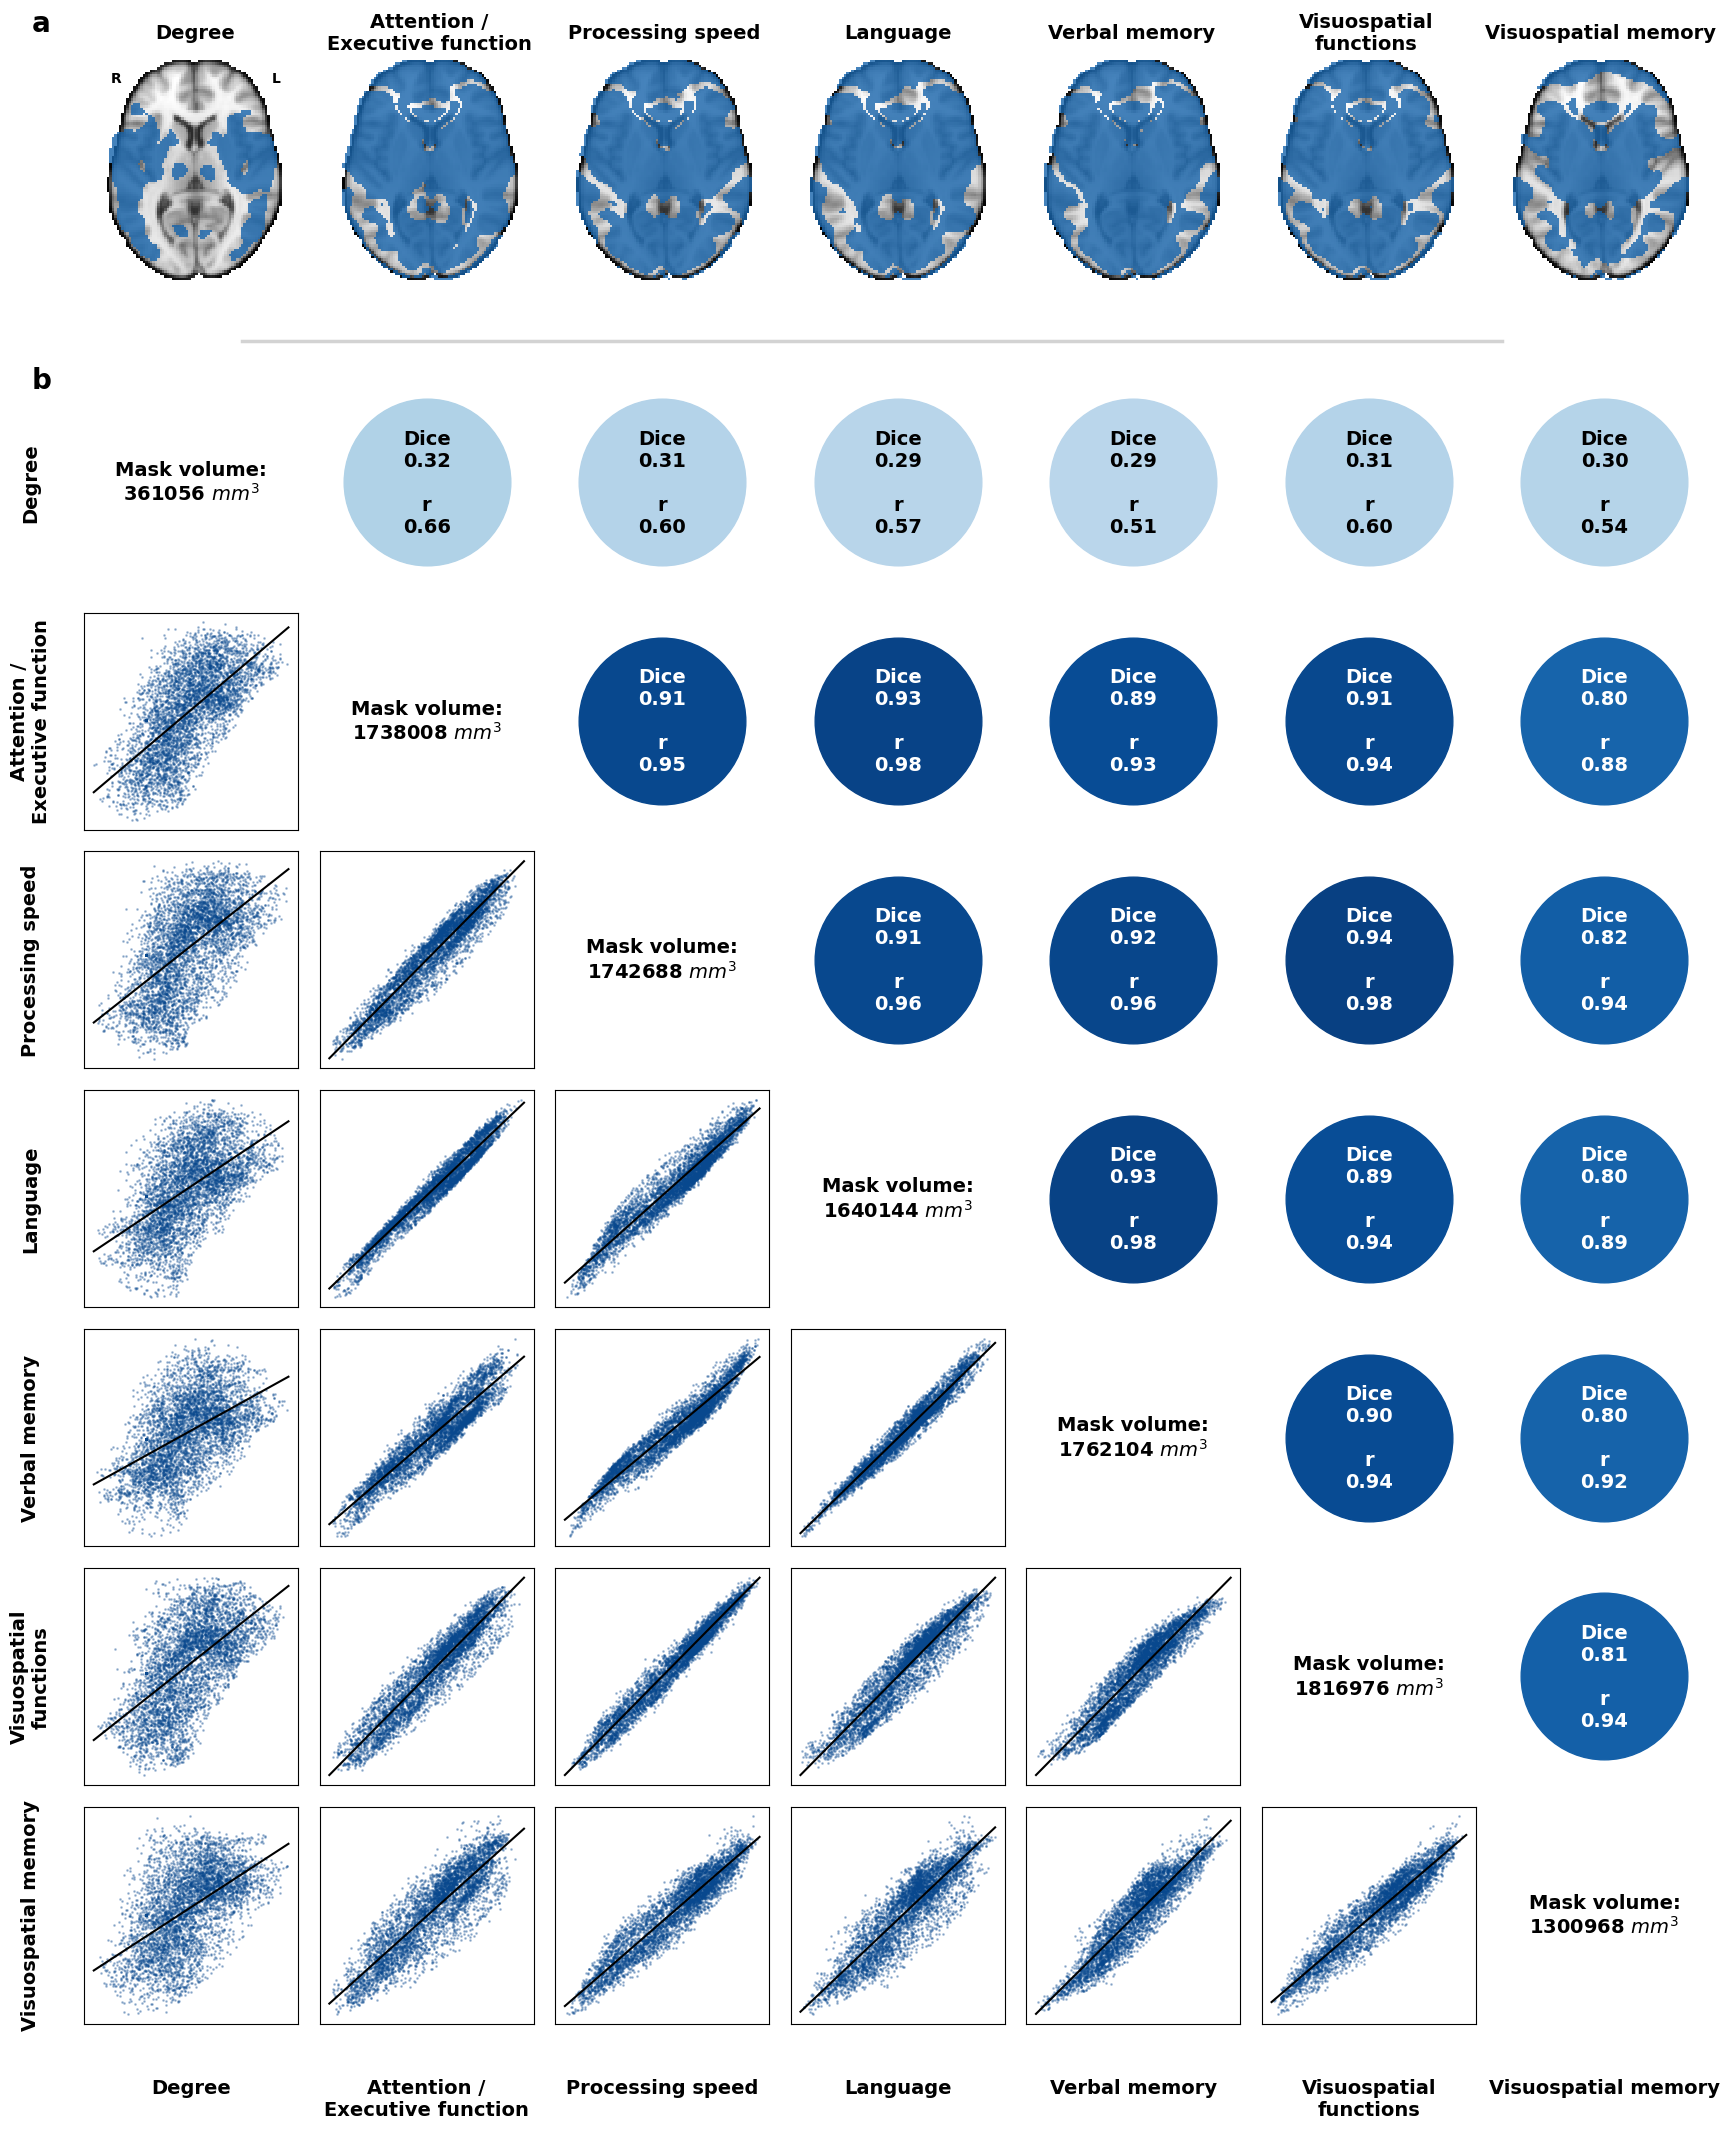

In [ ]:
import nibabel as nib

# Setup data
reference_affine = nib.load(flnm_degree_path).affine
binary_plot_dict = p_param_data_dict.copy()
continuous_plot_dict = tstat_data_dict.copy()

# Plot
fig = plot_combined_multimodal_figure(
    binary_dict=binary_plot_dict,
    continuous_dict=continuous_plot_dict,
    affine=reference_affine,
    bg_img=MNI_brain_img,
    label_rename_dict=variable_styling_dict,
    fontsize=14,
    figsize_base=3,
    dot_size_factor=1600,
    label_wrap_width=20
)

plt.savefig(OUTPUTS_DIR / "fLNM_param_multimodal_plot.png", dpi=600, bbox_inches='tight')
plt.show()

### Compute average similarity metrics

In [ ]:
# Use the same keys as your plot to ensure 'degree' is at index 0
keys_to_use = list(binary_plot_dict.keys()) 
dice_df, pearson_df = calculate_similarity_matrices(binary_plot_dict, continuous_plot_dict, keys=keys_to_use)

# Convert to numpy for specific indexing snippet
dice_matrix = dice_df.values
pearson_matrix = pearson_df.values

# Degree values
pearson_values_degree = pearson_matrix[-1, :-1]
dice_values_degree = dice_matrix[-1, :-1]

# Non-degree values
dice_matrix_wo_degree = dice_matrix[:-1, :-1]
pearson_matrix_wo_degree = pearson_matrix[:-1, :-1]

# Extract upper triangles to avoid double-counting or diagonal 1s
pearson_values_wo_degree = pearson_matrix_wo_degree[np.triu_indices_from(pearson_matrix_wo_degree, k=1)]
dice_values_wo_degree = dice_matrix_wo_degree[np.triu_indices_from(dice_matrix_wo_degree, k=1)]

print("Mean Pearson with degree:", round(pearson_values_degree.mean(), 2), 
      "+-", round(pearson_values_degree.std(), 2   ))
print("Mean Dice with degree:", round(dice_values_degree.mean(), 2), 
      "+-", round(dice_values_degree.std(), 2   ))
print("Mean Pearson without degree:", round(pearson_values_wo_degree.mean(), 2), 
      "+-", round(pearson_values_wo_degree.std(), 2   ))
print("Mean Dice without degree:", round(dice_values_wo_degree.mean(), 2), 
      "+-", round(dice_values_wo_degree.std(), 2   ))

Mean Pearson with degree: 0.58 +- 0.05
Mean Dice with degree: 0.3 +- 0.01
Mean Pearson without degree: 0.94 +- 0.03
Mean Dice without degree: 0.88 +- 0.05


# Permutation-based results

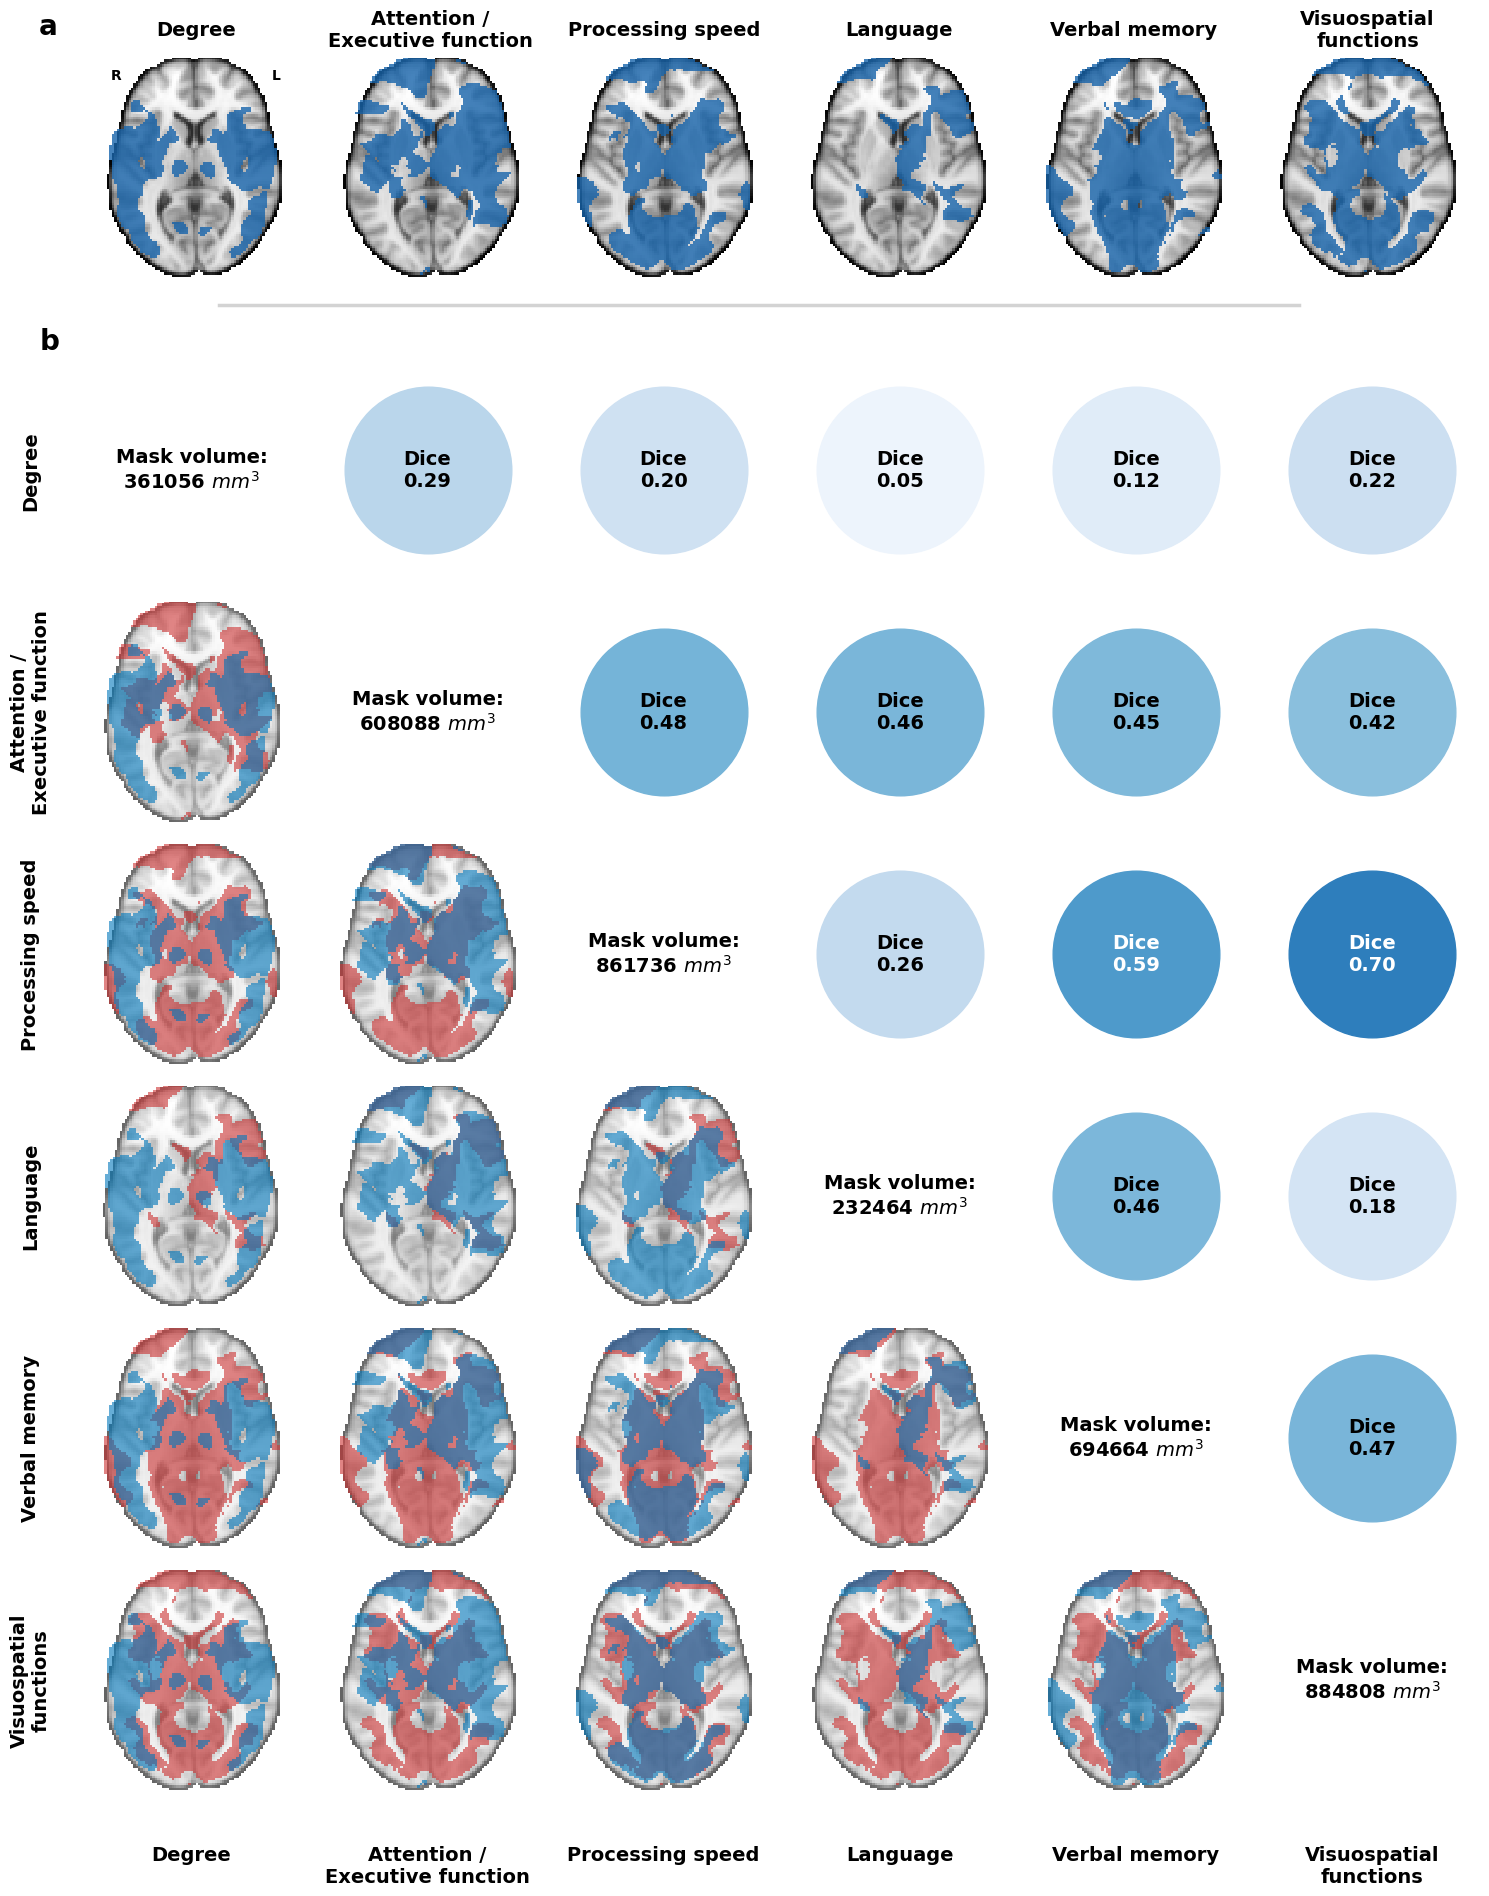

In [ ]:
import nibabel as nib

# Setup data
reference_affine = nib.load(flnm_degree_path).affine
binary_plot_dict = p_perm_data_dict.copy()

# Plot
fig = plot_combined_multimodal_figure(
    binary_dict=binary_plot_dict,
    continuous_dict=None,
    affine=reference_affine,
    bg_img=MNI_brain_img,
    label_rename_dict=variable_styling_dict,
    fontsize=14,
    figsize_base=3,
    dot_size_factor=1600,
    label_wrap_width=20
)

plt.savefig(OUTPUTS_DIR / "fLNM_perm_multimodal_overlap_matrix.png", dpi=600, bbox_inches='tight')
plt.show()

### Compute average similarity metrics

In [ ]:
# Use the same keys as your plot to ensure 'degree' is at index 0
keys_to_use = list(binary_plot_dict.keys()) 
dice_df, _ = calculate_similarity_matrices(binary_plot_dict, keys=keys_to_use)

# Convert to numpy for your specific indexing snippet
dice_matrix = dice_df.values

# Degree values
dice_values_degree = dice_matrix[-1, :-1]

# Non-degree values
dice_matrix_wo_degree = dice_matrix[:-1, :-1]

# Extract upper triangles to avoid double-counting or diagonal 1.0s
dice_values_wo_degree = dice_matrix_wo_degree[np.triu_indices_from(dice_matrix_wo_degree, k=1)]

print("Mean Dice with degree:", round(dice_values_degree.mean(), 2), 
      "+-", round(dice_values_degree.std(), 2   ))
print("Mean Dice without degree:", round(dice_values_wo_degree.mean(), 2), 
      "+-", round(dice_values_wo_degree.std(), 2   ))

Mean Dice with degree: 0.15 +- 0.1
Mean Dice without degree: 0.3 +- 0.24


# Comparison with lesion symptom mapping

In [ ]:
vlsm_tmap_paths = list(Path(OUTPUTS_DIR / "voxel_statistics" / "palm").glob("lesion_cognition-*/results_vox_tstat.nii"))
vlsm_p_paths = list(Path(OUTPUTS_DIR / "voxel_statistics" / "palm").glob("lesion_cognition-*/results_tfce_tstat_fdrp.nii"))

In [ ]:
PALM_DIR = OUTPUTS_DIR / ".." / "voxel_statistics" / "palm"

vlsm_tstat_data_dict = {}
vlsm_p_data_dict = {}

for DIR in PALM_DIR.glob("lesion_cognition-*"):
    tstat_path = DIR / "results_vox_tstat.nii"
    tstat_img = nib.load(tstat_path)
    tstat_img = nib.Nifti1Image(
        dataobj=np.where(brain_mask_img.get_fdata() > 0, tstat_img.get_fdata(), np.nan),
        affine=tstat_img.affine,
        header=tstat_img.header
    )
    tstat_data = tstat_img.get_fdata()

    vlsm_tstat_data_dict[DIR.name] = tstat_data

    p_path = DIR / "results_tfce_tstat_fdrp.nii"
    p_img = nib.load(p_path)
    p_img = nib.Nifti1Image(
        dataobj=np.where(brain_mask_img.get_fdata() > 0, p_img.get_fdata(), np.nan),
        affine=p_img.affine, 
        header=p_img.header
    )
    p_data = p_img.get_fdata()

    p_signif = p_data > -np.log10(0.05)
    vlsm_p_data_dict[DIR.name] = p_signif

In [ ]:
p_perm_data_dict_plotting = {k.replace("fLNM_", ""): v for k, v in p_perm_data_dict.items()}
del p_perm_data_dict_plotting["degree"]

p_param_data_dict_plotting = {k.replace("fLNM_", ""): v for k, v in p_param_data_dict.items()}
del p_param_data_dict_plotting["degree"]

Found 6 matching comparisons: ['cognition-aef_domain_score', 'cognition-language_domain_score', 'cognition-ps_domain_score', 'cognition-verbalmemory_domain_score', 'cognition-vsfunctions_domain_score', 'cognition-vsmemory_domain_score']


/tmp/ipykernel_47239/3553834238.py:66: UserWarning: empty mask
  display = plotting.plot_stat_map(


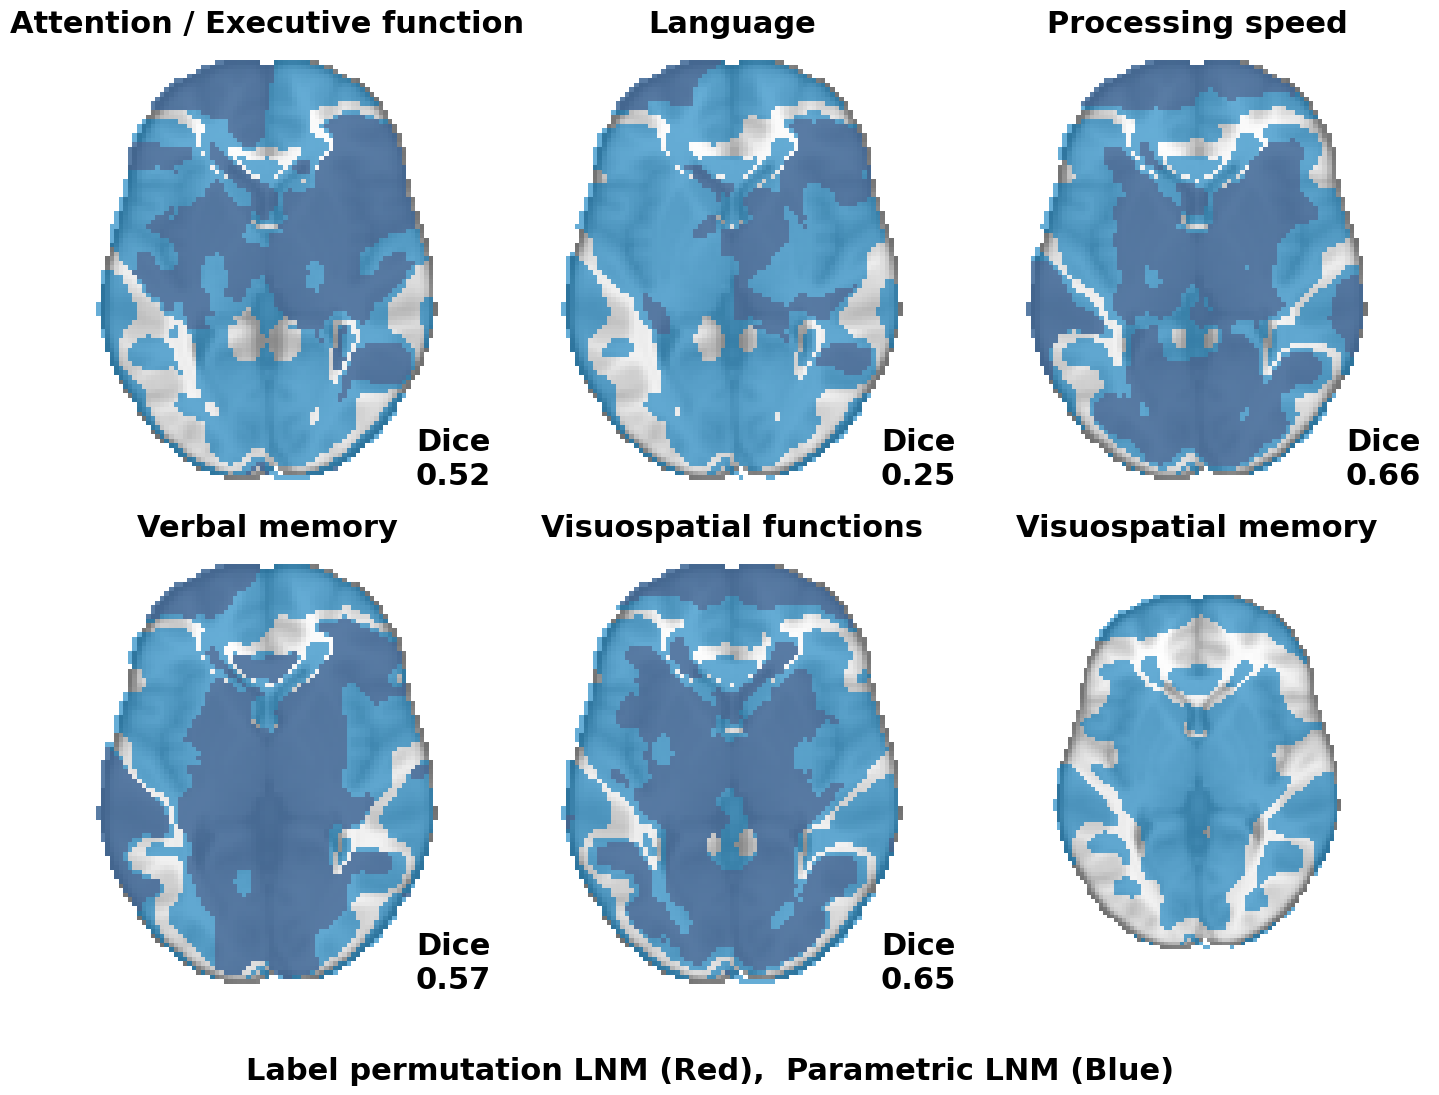

In [ ]:
fig, axes, dice_scores = plot_binary_comparison(
    binary_dict1=p_perm_data_dict_plotting,
    binary_dict2=p_param_data_dict_plotting,
    affine=flnm_degree_img.affine,
    label_rename_dict=variable_styling_dict,
    labeltext="Label permutation LNM (Red),  Parametric LNM (Blue)",
    fontsize=22,
    bg_img=MNI_brain_img
)

plt.savefig(OUTPUTS_DIR / "paramlnm_permlnm_comparison_matrix.png", dpi=600)

plt.show()

In [ ]:
# Print mean and std of Dice scores (excluding visuospatial memory as it is n.s.)
print("Mean Dice score:", round(np.mean(dice_scores[:-1]), 2), "+-", round(np.std(dice_scores[:-1]), 2))

Mean Dice score: 0.53 +- 0.15


In [152]:
# remove fLNM_ from keys
p_data_dict_plotting = {k.replace("fLNM_", ""): v for k, v in p_perm_data_dict.items()}
tstat_data_dict_plotting = {k.replace("fLNM_", ""): v for k, v in tstat_data_dict.items()}

# remove lesion_ from keys
vlsm_p_data_dict_plotting = {k.replace("lesion_", ""): v for k, v in vlsm_p_data_dict.items()}
vlsm_tstat_data_dict_plotting = {k.replace("lesion_", ""): v for k, v in vlsm_tstat_data_dict.items()}

Found 6 matching comparisons: ['cognition-aef_domain_score', 'cognition-language_domain_score', 'cognition-ps_domain_score', 'cognition-verbalmemory_domain_score', 'cognition-vsfunctions_domain_score', 'cognition-vsmemory_domain_score']


/tmp/ipykernel_47239/3553834238.py:66: UserWarning: empty mask
  display = plotting.plot_stat_map(


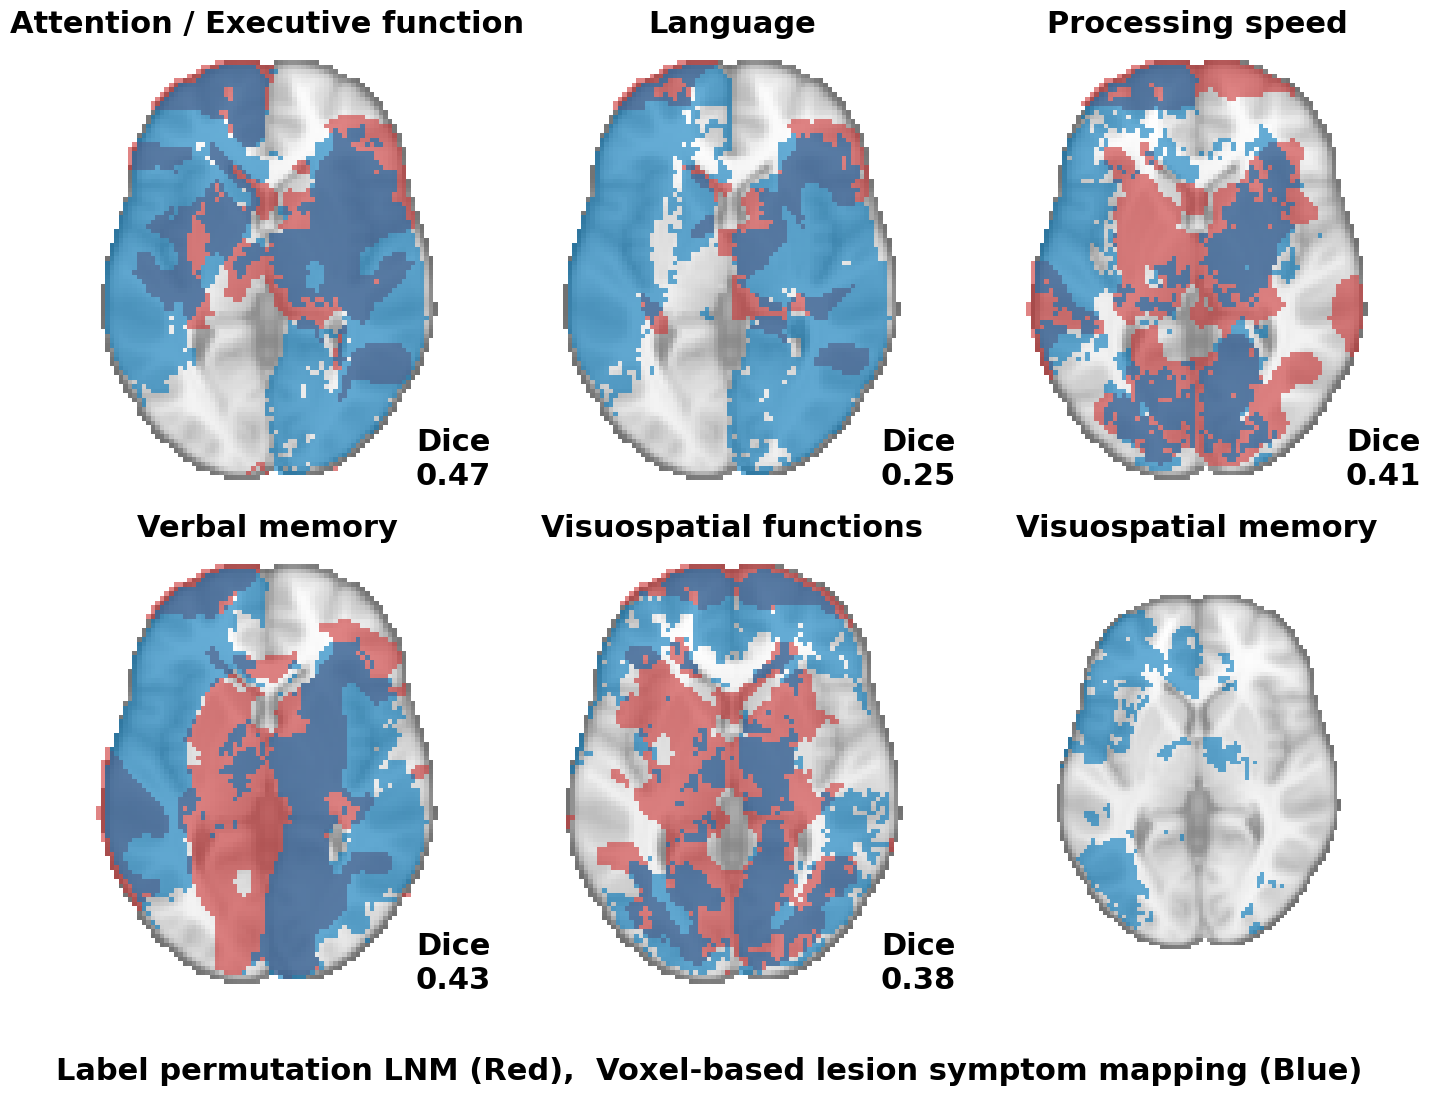

In [154]:
fig, axes, dice_scores = plot_binary_comparison(
    binary_dict1=p_data_dict_plotting,         # From your LNM loading cell
    binary_dict2=vlsm_p_data_dict_plotting,   # Assuming this variable exists
    affine=flnm_degree_img.affine,        # Using affine from one of the loaded images
    label_rename_dict=variable_styling_dict,
    labeltext="Label permutation LNM (Red),  Voxel-based lesion symptom mapping (Blue)",
    fontsize=22,
    bg_img=MNI_brain_img
)

plt.savefig(OUTPUTS_DIR / "lnm_vlsm_comparison_matrix.png", dpi=600)

plt.show()



In [ ]:
# Visuospatial memory again excluded
print("Mean Dice score:", round(np.mean(dice_scores[:-1]), 2), "+-", round(np.std(dice_scores[:-1]), 2))

Mean Dice score: 0.39 +- 0.07
